#bike


In [83]:

import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/ikwak2/hj19_timeseries/main/bike_pm2.5/SeoulBikeData%20(1).csv?token=ATB7FV3LACXEJIJXMV3DQDLBMQM56")

In [84]:
data['Holiday']=data['Holiday'].factorize()[0]

In [85]:
data['Seasons']=data['Seasons'].factorize()[0]
data['Functioning Day']=data['Functioning Day'].factorize()[0]

In [86]:
data['Rented Bike Count']

0        254
1        204
2        173
3        107
4         78
        ... 
8755    1003
8756     764
8757     694
8758     712
8759     584
Name: Rented Bike Count, Length: 8760, dtype: int64

In [87]:
data=data.drop(['Hour'],axis=1)

In [88]:
data.columns[1:-3]

Index(['Rented Bike Count', 'Temperature', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature', 'Solar Radiation (MJ/m2)',
       'Rainfall(mm)', 'Snowfall (cm)'],
      dtype='object')

In [89]:
cols=data.columns[1:-3] 
len(cols)

9

In [90]:
from sklearn.preprocessing import MinMaxScaler
values = data[cols].values.reshape(-1,9)
values = values.astype('float32')
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled=scaler.fit_transform(values)
scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))
#scaled = (values - np.mean(values))/np.std(values) 

In [91]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 7 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if values[row,0]==0:
                values[row,0] = values[row - one_day,0]

In [92]:
fill_missing(values)

In [93]:
sum(pd.DataFrame(values)[0]==0)

0

In [94]:

train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:]
print(len(train),len(val), len(test))

7008 876 876


In [95]:

def create_dataset_multistep(dataset, look_back=1,predict=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-predict):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i+ look_back-1: i+ look_back+predict-1, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [96]:
look_back = 168
predict=24

trainX, trainY = create_dataset_multistep(train, look_back,predict)
valX, valY = create_dataset_multistep(val, look_back,predict)
testX, testY = create_dataset_multistep(test, look_back,predict)

6816
684
684


In [97]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [98]:
class CharacterTable(object):
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

In [99]:
from tensorflow.keras.models import Model

cnn-lstm

In [100]:
first_input = Input(shape=(168,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(100, return_sequences=False)(in1)
#in1=RepeatVector(24)(in1)
#in1=LSTM(50, return_sequences=True)(in1)
#in1=Dropout(0.3)(in1)
in1=Dense(100)(in1)
#in1=RepeatVector(24)(in1)

in1=Dropout(0.3)(in1)
out=Dense(24)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/bike_1cnnlstm.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history=model.fit(trainX, trainY, epochs=30, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

In [101]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/bike_1cnnlstm.hdf5")

In [102]:
SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

In [103]:
id_=24*24+12

testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)

[0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


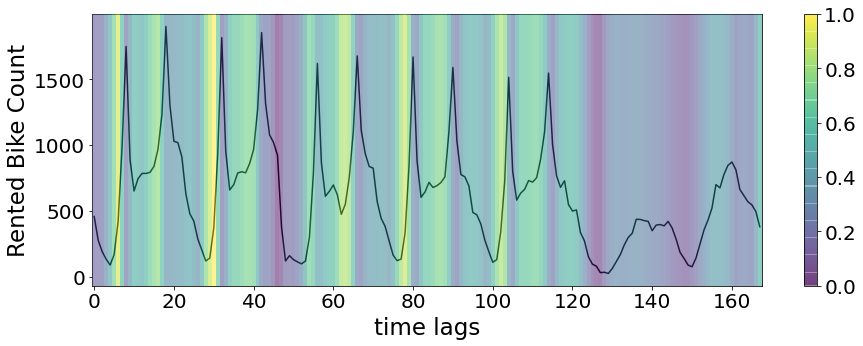

In [104]:
from scipy.ndimage import zoom
import random
import pylab

#id_=24*20


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse,'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Rented Bike Count'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/png1/bike_grad cam_cnn-lstm.png', dpi=300)

(1, 168, 9)


<Figure size 432x1440 with 0 Axes>

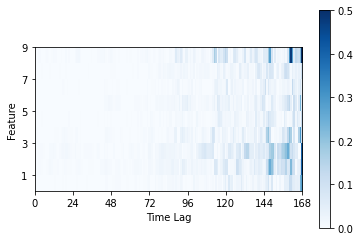

In [114]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[4], model)

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,9)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 168, 0 , 9]
y_label_list = [1,3,5,7,9]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([10,30,50,70,90])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time Lag')

plt.imshow(a,extent = [0 , 168, 0 , 90], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/png/bike_feature importance_cnn-lstm(1).png')

lstm-cnn

In [118]:
first_input = Input(shape=(168,9))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)


#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)




in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=Dropout(0.5)(in1)

out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/bike_lstmcnn_multi.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history=model.fit(trainX, trainY,validation_data=[valX,valY],epochs=30, verbose=1, callbacks=[cb])

Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 168, 9)]          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 168, 64)           18944     
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 168, 64)           12352     
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 168, 64)           8256      
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 168, 64)           4160      
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 168, 64)           12352     
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 168, 64)         

In [119]:
model.load_weights('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/bike_lstmcnn_multi.hdf5')

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


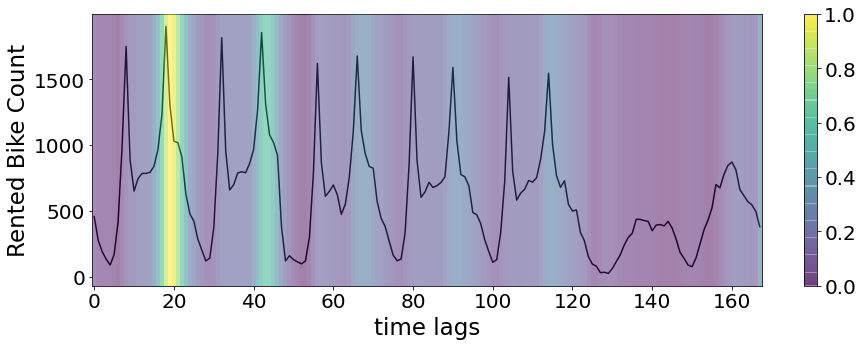

In [123]:
from scipy.ndimage import zoom
import random
import pylab

#id_=24*20


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse,'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Rented Bike Count'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/png1/bike_grad cam_lstm-cnn.png', dpi=300)

(1, 168, 9)


<Figure size 432x1440 with 0 Axes>

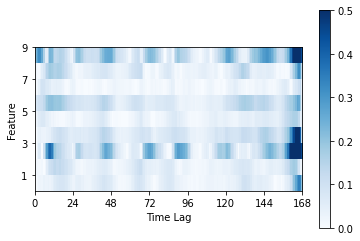

In [119]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[4], model)

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,9)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 168, 0 , 9]
y_label_list = [1,3,5,7,9]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([10,30,50,70,90])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time Lag')

plt.imshow(a,extent = [0 , 168, 0 , 90], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/png/bike_feature importance_lstm-cnn(1).png')

lstm-rescnn

In [112]:
first_input = Input(shape=(168,9))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#ad1=add([in0,in1])


#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_sizaae=2, name='extractor')(in1)
in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)

in1=Dropout(0.5)(in1)
out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/bike_reslstmcnn_multi1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=False,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history=model.fit(trainX, trainY,validation_data=[valX,valY],epochs=30, verbose=1,callbacks=[cb])

Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 168, 9)]     0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 168, 64)      18944       input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_47 (Conv1D)              (None, 168, 64)      12352       lstm_8[0][0]                     
__________________________________________________________________________________________________
conv1d_48 (Conv1D)              (None, 168, 64)      8256        conv1d_47[0][0]                  
______________________________________________________________________________________

In [113]:
model.load_weights('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/bike_reslstmcnn_multi2.hdf5')

[0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


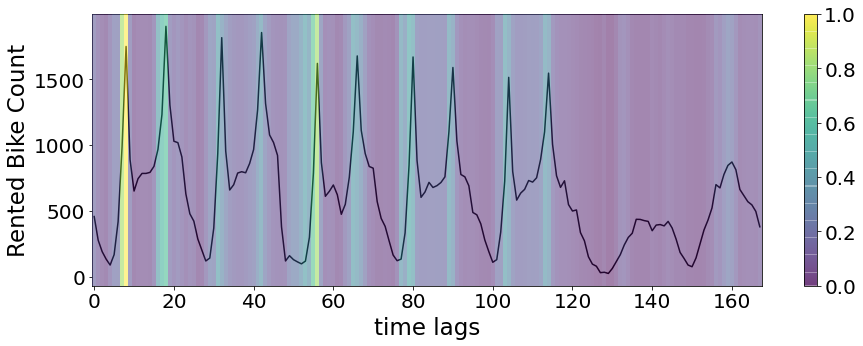

In [115]:

from scipy.ndimage import zoom
import random
import pylab

#id_=24*20


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse,'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Rented Bike Count'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/png/bike_grad cam_lstm-rescnn.png', dpi=300)

In [124]:
X_test=testX
grad_weight = gradient_weight(X_test[4], model)
grad_weight_abs = abs(grad_weight)
print(np.max(grad_weight_abs))
print(grad_weight_abs)

1.0253315
tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]], shape=(1, 168, 9), dtype=float32)


In [125]:
grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))
print(np.max(grad_weight_abs_z))
print(grad_weight_abs_z)

1.0
tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]], shape=(1, 168, 9), dtype=float32)


(1, 168, 9)


<Figure size 432x1440 with 0 Axes>

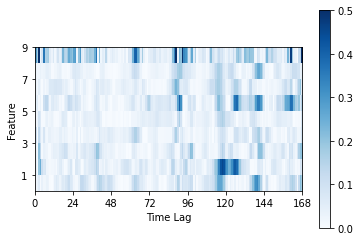

In [126]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[4], model)

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,9)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 168, 0 , 9]
y_label_list = [1,3,5,7,9]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([10,30,50,70,90])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time Lag')

plt.imshow(a,extent = [0 , 168, 0 , 90], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/png/bike_feature importance_lstm-rescnn(1).png')